<a href="https://colab.research.google.com/github/sultanmr/travel-tide/blob/main/TravelTide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime

# Data Loading and Initial Exploration

In [2]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSQG-wCbO5UkiHOfPbExP0OkKkLg8qJ2w2PGlbP1prp8TpndCfAuFqe8W7VO4JXhYVeuCcA-TxNvNdb/pub?gid=389458990&single=true&output=csv"
'''
The above URL does contain the following filtered data:

WITH session_counts AS (
    SELECT
        DISTINCT s.user_id
    FROM
        sessions s
    WHERE
        s.session_start > '2023-01-04'
    GROUP BY
        s.user_id
    HAVING
        COUNT(*) > 7
)

SELECT
  u.user_id,
  u.home_country,
  u.gender,
  s.session_id,
  s.session_start,
  s.session_end,
  f.trip_id,
  f.destination,
  h.trip_id,
  h.hotel_name
FROM
    session_counts sc
LEFT JOIN users u ON u.user_id = sc.user_id
LEFT JOIN sessions s ON s.user_id = sc.user_id
LEFT JOIN flights f ON s.trip_id = f.trip_id
LEFT JOIN hotels h ON s.trip_id = h.trip_id

WHERE
		h.nights>0 AND h.rooms>0
ORDER BY
    u.user_id, s.session_start;
LEFT JOIN hotels h ON s.trip_id = h.trip_id
'''

"\nThe above URL does contain the following filtered data:\n\nWITH session_counts AS (\n    SELECT\n        DISTINCT s.user_id\n    FROM\n        sessions s\n    WHERE\n        s.session_start > '2023-01-04'\n    GROUP BY\n        s.user_id\n    HAVING\n        COUNT(*) > 7\n)\n\nSELECT\n  u.user_id,\n  u.home_country,\n  u.gender,\n  s.session_id,\n  s.session_start,\n  s.session_end,\n  f.trip_id,\n  f.destination,\n  h.trip_id,\n  h.hotel_name\nFROM\n    session_counts sc\nLEFT JOIN users u ON u.user_id = sc.user_id\nLEFT JOIN sessions s ON s.user_id = sc.user_id\nLEFT JOIN flights f ON s.trip_id = f.trip_id\nLEFT JOIN hotels h ON s.trip_id = h.trip_id\n\nWHERE\n\t\th.nights>0 AND h.rooms>0\nORDER BY\n    u.user_id, s.session_start;\nLEFT JOIN hotels h ON s.trip_id = h.trip_id\n"

In [3]:
data = pd.read_csv(url, index_col="user_id")

# Initial Data Exploration
print(data.head())
print(data.columns)
print(data.dtypes)
print(data['gender'].value_counts())
data = data[data['gender'] != 'O']
print(data.isnull().sum())
print(data["home_country"].value_counts())

          birthdate gender  married  has_children home_country    home_city  \
user_id                                                                       
23557    1958-12-08      F     True         False          usa     new york   
23557    1958-12-08      F     True         False          usa     new york   
23557    1958-12-08      F     True         False          usa     new york   
94883    1972-03-16      F     True         False          usa  kansas city   
101486   1972-12-07      F     True          True          usa       tacoma   

        home_airport  home_airport_lat  home_airport_lon sign_up_date  ...  \
user_id                                                                ...   
23557            LGA            40.777           -73.872   2021-07-22  ...   
23557            LGA            40.777           -73.872   2021-07-22  ...   
23557            LGA            40.777           -73.872   2021-07-22  ...   
94883            MCI            39.297           -94.714

# Data Preprocessing

In [4]:
data["married"] = data["married"].astype("int")
data["has_children"] = data["has_children"].astype("int")
data["gender"] = (data["gender"] == 'F').astype("int")
data["home_country"] = (data["home_country"] == 'canada').astype("int")

print(data.describe(include="all"))
print(data.dtypes)

         birthdate        gender       married  has_children  home_country  \
count        13978  13978.000000  13978.000000  13978.000000  13978.000000   
unique        4289           NaN           NaN           NaN           NaN   
top     1979-01-06           NaN           NaN           NaN           NaN   
freq            17           NaN           NaN           NaN           NaN   
mean           NaN      0.886035      0.441193      0.304335      0.176349   
std            NaN      0.317780      0.496547      0.460142      0.381130   
min            NaN      0.000000      0.000000      0.000000      0.000000   
25%            NaN      1.000000      0.000000      0.000000      0.000000   
50%            NaN      1.000000      0.000000      0.000000      0.000000   
75%            NaN      1.000000      1.000000      1.000000      0.000000   
max            NaN      1.000000      1.000000      1.000000      1.000000   

       home_city home_airport  home_airport_lat  home_airport_l

# Adding New Features

In [5]:
data['birthdate']  = pd.to_datetime(data['birthdate'])
data['age'] = (datetime.now() - data['birthdate']).dt.days // 365

In [6]:
# Aggregate user travel behavior (metrics related to valid trips)
def haversine_distance(lat1, lon1, lat2, lon2):
    # Haversine formula to calculate distance between two points on Earth
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

data['travel_distance_km'] = haversine_distance(data['home_airport_lat'], data['home_airport_lon'], data['destination_airport_lat'], data['destination_airport_lon'])
data['travel_distance_km'] = data['travel_distance_km'].fillna(data['travel_distance_km'].mean())

In [7]:
# Flight and Hotel Booking Correlation (same session booking)
data['flight_hotel_booked'] = (data['flight_booked'] & data['hotel_booked']).astype(int)

In [8]:
# Flight Duration (difference between departure and return times)
data['flight_duration_days'] = (pd.to_datetime(data['return_time']) - pd.to_datetime(data['departure_time'])).dt.days
flight_duration_days_mean = round(data['flight_duration_days'].mean())
data['flight_duration_days'] = data['flight_duration_days'].fillna(flight_duration_days_mean)

In [9]:
# Hotel Stay Duration (difference between check-in and check-out)
data['hotel_stay_duration'] = (pd.to_datetime(data['check_out_time']) - pd.to_datetime(data['check_in_time'])).dt.days

In [10]:
# Total Hotel Room Cost
data['total_hotel_cost'] = data['hotel_per_room_usd'] * data['rooms']

In [11]:
# Active Days (days since user signed up)
data['active_days'] = (datetime.now() - pd.to_datetime(data['sign_up_date'])).dt.days

In [12]:
# Cancellation Rate (proportion of cancelled flights)
user_cancellations = data.groupby('user_id')['cancellation'].mean().reset_index()
user_cancellations.columns = ['user_id', 'cancellation_rate']
data = pd.merge(data, user_cancellations, on='user_id', how='left')

# Feature Selection & Encoding

In [13]:
features = [
    'gender', 'married', 'has_children', 'flight_booked',
    'page_clicks', 'cancellation', 'seats', 'checked_bags',
    'base_fare_usd', 'nights', 'rooms', 'hotel_per_room_usd',
    'travel_distance_km', 'age', 'flight_hotel_booked', 'flight_duration_days',
    'hotel_stay_duration', 'total_hotel_cost', 'active_days',
    'cancellation_rate'
]
#data_numeric = data[features].copy()
data_numeric = data[["user_id"] + features].copy()
data_numeric["gender"] = data_numeric["gender"].astype("category").cat.codes
data_numeric["married"] = data_numeric["married"].astype("category").cat.codes
data_numeric["has_children"] = data_numeric["has_children"].astype("category").cat.codes

# Fill missing values
data_numeric['base_fare_usd'] = data_numeric['base_fare_usd'].fillna(data_numeric['base_fare_usd'].mean())
data_numeric['seats'] = data_numeric['seats'].fillna(round(data_numeric['seats'].median()))
data_numeric['checked_bags'] = data_numeric['checked_bags'].fillna(round(data_numeric['checked_bags'].median()))


In [14]:
data_numeric.isnull().sum()

,0
user_id,0
gender,0
married,0
has_children,0
flight_booked,0
page_clicks,0
cancellation,0
seats,0
checked_bags,0
base_fare_usd,0


# Data Scaling

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numeric[features])

# PCA Visualization

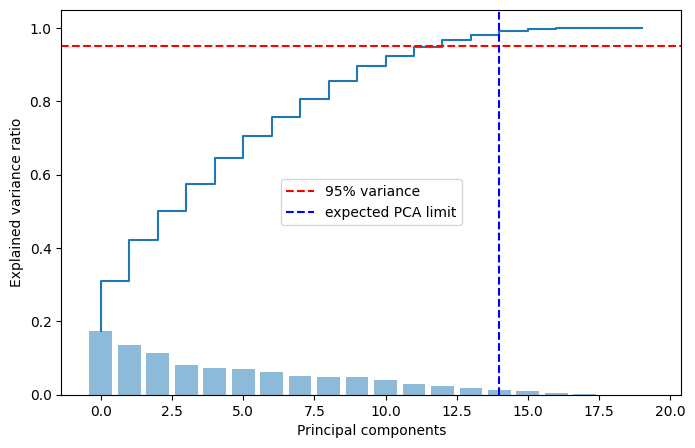

In [33]:
pca = PCA()
pca.fit(X_scaled)
plt.figure(figsize=(8, 5))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_, alpha=0.5)
plt.step(range(pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance")
plt.axvline(x=14, color='b', linestyle='--', label="expected PCA limit")
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend()
plt.show()

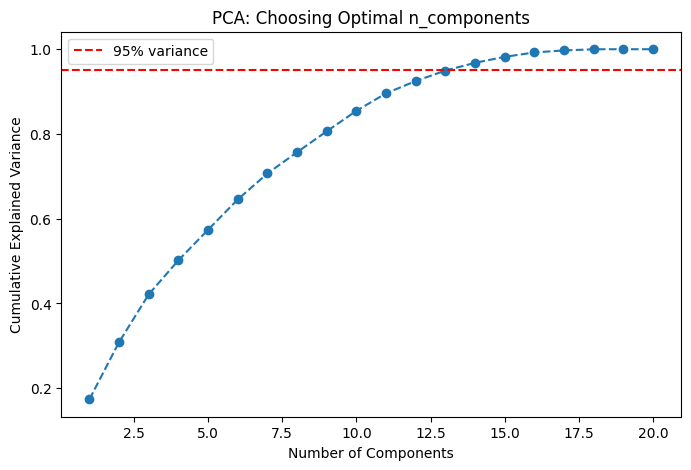

In [16]:
# Apply PCA without reducing dimensions (to analyze variance)
PCA().fit(X_scaled)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Choosing Optimal n_components")
plt.legend()
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Selected components:", pca.n_components_)
n = pca.n_components_

Selected components: 14


<ipython-input-200-f9d69da95293>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_viz, x="pca_0", y="pca_1", palette="Blues", s=100, edgecolor='black')
<ipython-input-200-f9d69da95293>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cluster")


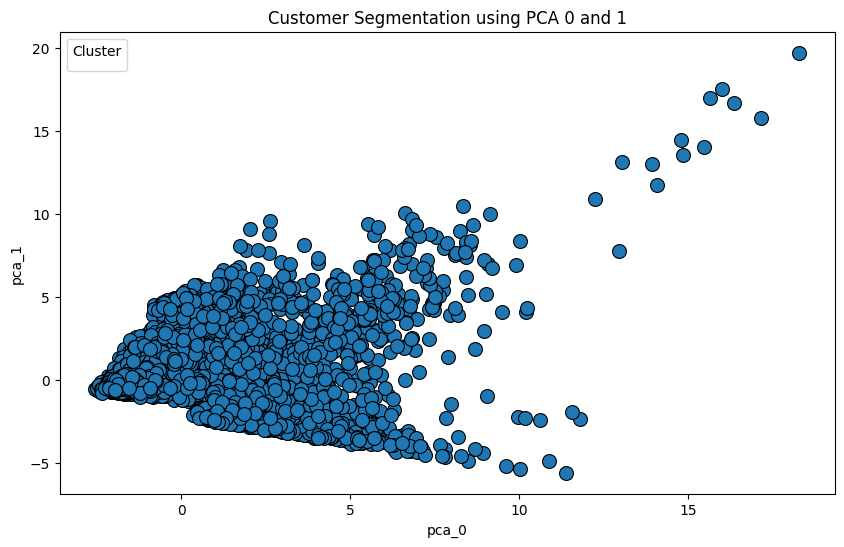

<ipython-input-200-f9d69da95293>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_viz, x="pca_1", y="pca_2", palette="Blues", s=100, edgecolor='black')
<ipython-input-200-f9d69da95293>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cluster")


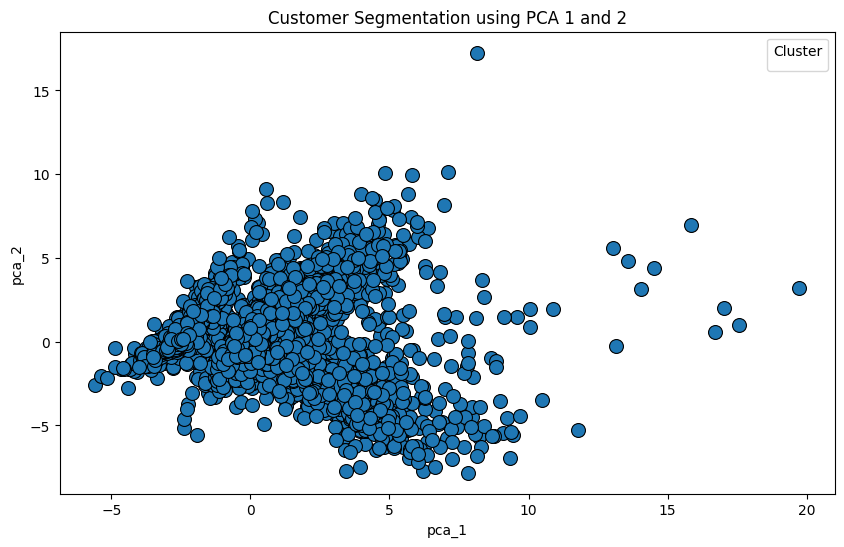

<ipython-input-200-f9d69da95293>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


Text(0.5, 0.92, '3D PCA Visualization')

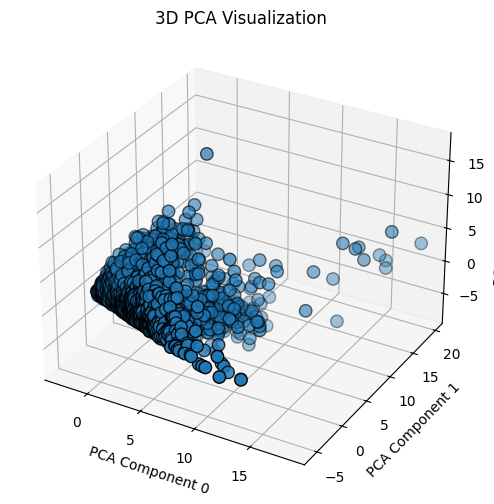

In [ ]:
pca = PCA(n_components=n)
X_pca = pca.fit_transform(X_scaled)
cols = [f"pca_{i}" for i in range (n)]
pca_viz = pd.DataFrame(X_pca, columns=cols)


plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_viz, x="pca_0", y="pca_1", palette="Blues", s=100, edgecolor='black')
plt.title("Customer Segmentation using PCA 0 and 1")
plt.legend(title="Cluster")
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_viz, x="pca_1", y="pca_2", palette="Blues", s=100, edgecolor='black')
plt.title("Customer Segmentation using PCA 1 and 2")
plt.legend(title="Cluster")
plt.grid(False)
plt.show()


ax = plt.figure(figsize=(10, 6)).add_subplot(111, projection="3d")
ax.scatter(
    pca_viz["pca_0"], pca_viz["pca_1"], pca_viz["pca_2"],

    cmap="Blues", edgecolors="black", s=80
)

ax.set_xlabel("PCA Component 0")
ax.set_ylabel("PCA Component 1")
ax.set_zlabel("PCA Component 2")
ax.set_title("3D PCA Visualization")


# Finding Optimal Number of Clusters (Elbow Method)

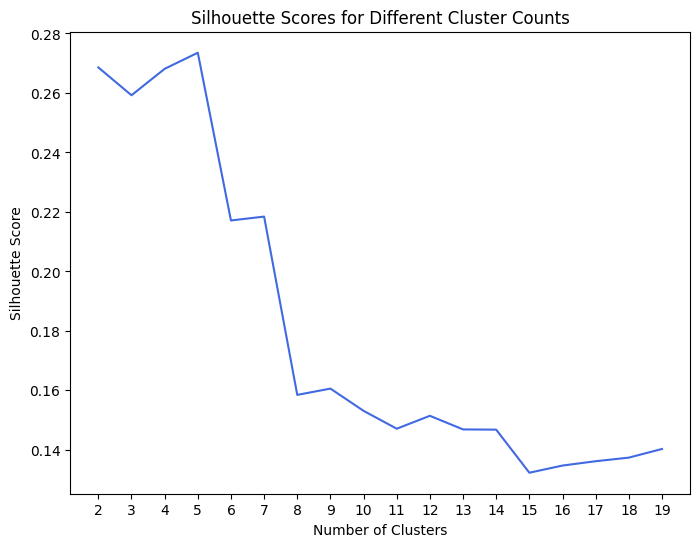

In [ ]:
scores = []

for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    groups = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, groups)
    scores.append(score)


# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(2, 20), y=scores, color='royalblue')
plt.xticks(range(2, 20))
plt.title("Silhouette Scores for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(False)
plt.show()

In [ ]:
score_differences = abs(np.diff(scores))
best_n_clusters = np.argmax(score_differences)+3 # 3=> 2+1 => 2:start index, 1: we need next point, not previous

best_score = score_differences[best_n_clusters]
# Output the best number of clusters and its score
print(f"Best number of clusters: {best_n_clusters } ")
print(f"Best Silhouette Score: {best_score}")

Best number of clusters: 8 
Best Silhouette Score: 0.006010302037425086


# KMeans Clustering

In [ ]:
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
groups = kmeans.fit_predict(X_pca)
data_numeric["cluster"] = groups
data["cluster"] = groups
print(data_numeric["cluster"].value_counts())

cluster
6    4327
4    3463
0    2458
3    1275
7    1140
1     783
5     366
2     166
Name: count, dtype: int64


# Cluster Analysis

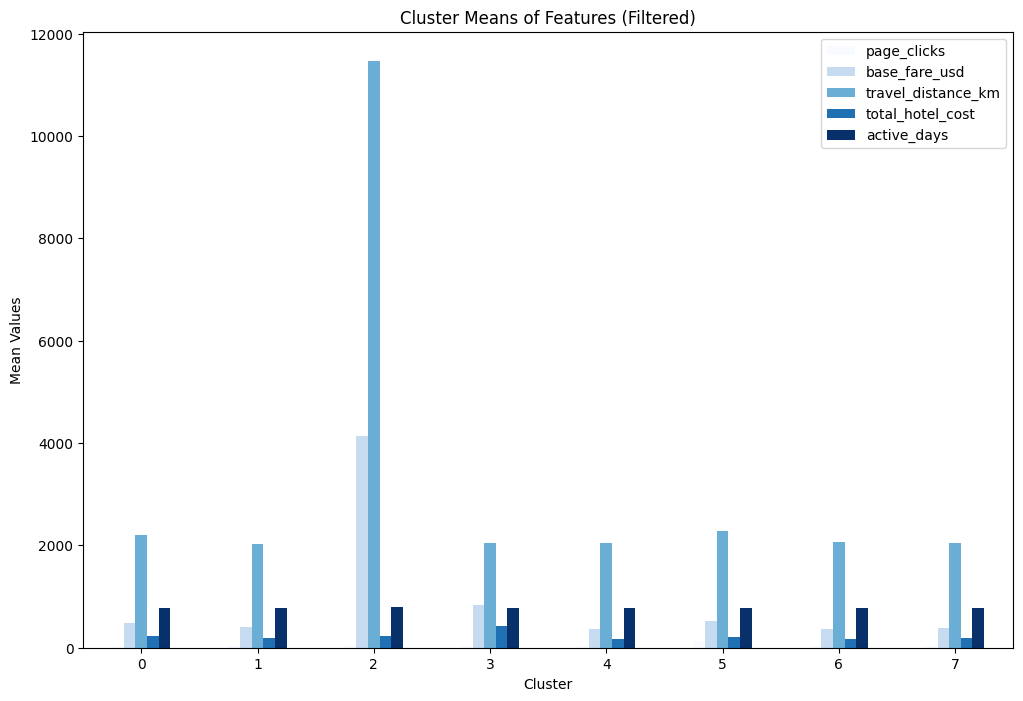

In [ ]:
data_numeric2 = data_numeric.select_dtypes(exclude=["object"]).copy()
data_numeric2.drop("user_id", axis=1, inplace=True)
cluster_means = data_numeric2.groupby("cluster").mean()

# Calculate the variance of each feature across clusters
feature_variances = cluster_means.var()

# Set a threshold for low variance (e.g., features with variance less than a threshold will be removed)
low_variance_threshold = 100
features_to_keep = feature_variances[feature_variances > low_variance_threshold].index

# Filter the cluster means dataframe to keep only features with sufficient variance
cluster_means_filtered = cluster_means[features_to_keep]

# Plotting the bar plot for filtered features
cluster_means_filtered.plot(kind='bar', figsize=(12, 8), cmap='Blues')
plt.title('Cluster Means of Features (Filtered)')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

In [ ]:
data_numeric['cluster'].value_counts()

,count
cluster,
6,4327
4,3463
0,2458
3,1275
7,1140
1,783
5,366
2,166


In [ ]:
cluster_means.to_csv("cluster_means.csv", index=True)


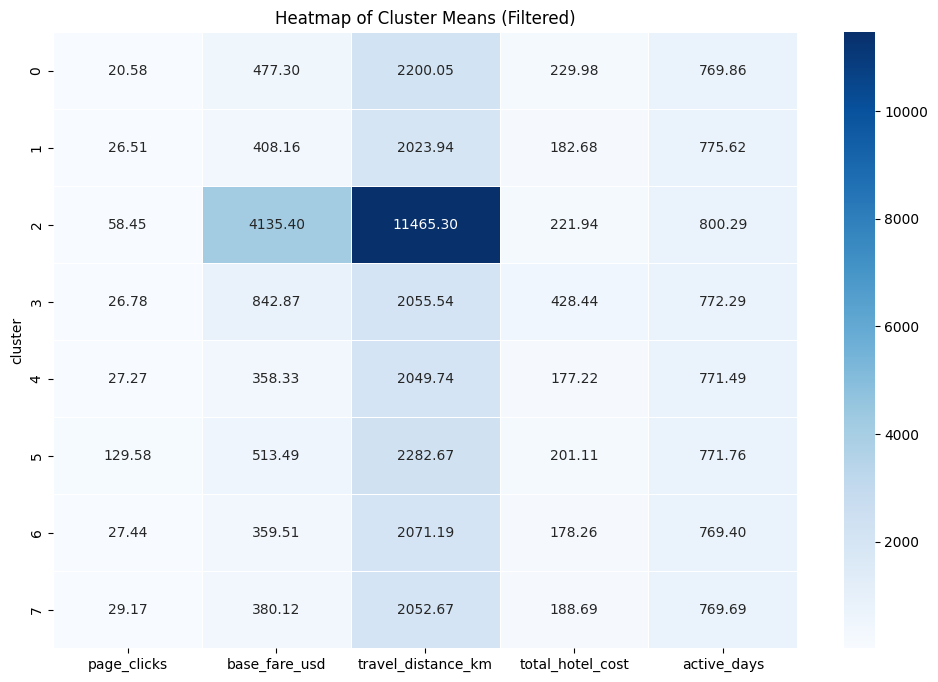

In [ ]:
# Plotting the heatmap for filtered cluster means
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_filtered, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Cluster Means (Filtered)')
plt.show()


# Recommended Offers per Cluster

In [ ]:
# Offers to map
offers = [
    "10% off next trip",
    "Discount at special events",
    "Free child ticket",
    "Free meal",
    "Meal voucher",
    "Free child ticket"
]

# Define custom mapping logic based on customer behavior and cluster
def behavior_based_offer(row):
    # Cluster 0: Frequent Flyers
    if row['cluster'] == 0:
        if row['flight_booked'] > 2:
            return "10% off next trip"
        elif row['flight_booked'] == 1:
            return "Meal voucher"
        else:
            return "Free meal"

    # Cluster 1: Budget-conscious travelers
    elif row['cluster'] == 1:
        if row['base_fare_usd'] < 400:
            return "Discount at special events"
        else:
            return "Free meal"

    # Cluster 2: Luxury-seeking travelers
    elif row['cluster'] == 2:
        if row['total_hotel_cost'] > 500:
            return "Free meal"
        elif row['base_fare_usd'] > 800:
            return "10% off next trip"
        else:
            return "Discount at special events"

    # Cluster 3: Family-oriented travelers
    elif row['cluster'] == 3:
        if row['seats'] > 1:
            return "Free child ticket"
        else:
            return "Meal voucher"

    # Cluster 4: Occasional travelers
    elif row['cluster'] == 4:
        if row['active_days'] > 10:
            return "Discount at special events"
        else:
            return "Free meal"

    # Default case (fallback if no condition matches)
    return "Meal voucher"

# User level Mapping

In [ ]:
# Aggregate user-level features (Example: Average spend, total trips, engagement)
user_features = data.groupby("user_id").agg({
    "flight_booked": "mean",
    "base_fare_usd": "mean",
    "seats": "mean",
    "active_days": "mean",
    "total_hotel_cost": "mean",
    "nights": "mean",
    "cluster": lambda x:  int(x.mode()[0])   # Get the most frequent cluster
}).reset_index()

user_features["recommended_offer"] = user_features.apply(behavior_based_offer, axis=1)

In [ ]:
user_features[['user_id', 'recommended_offer']].to_csv("user_offers.csv", index=False)

<ipython-input-211-f4bd9f1aaa19>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=data, palette='Blues')


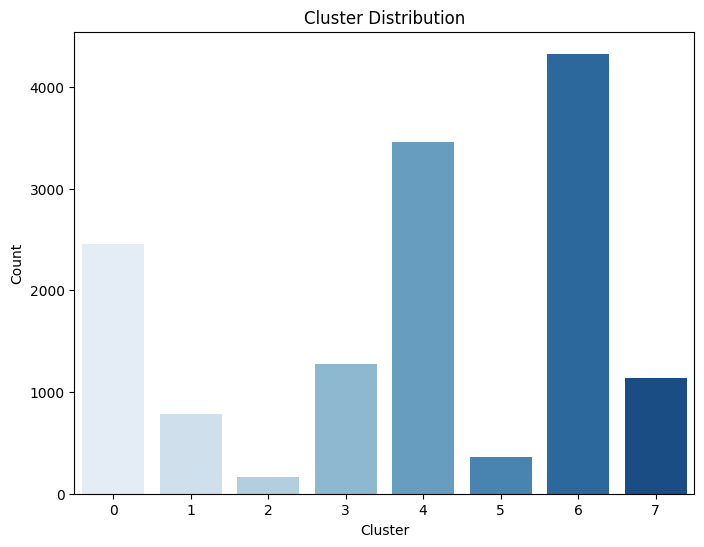

In [ ]:
# Get the count of each cluster value
cluster_counts = data['cluster'].value_counts().reset_index(name='count')
cluster_counts.columns = ['cluster', 'count']  # Rename columns for clarity

# Create a countplot for the clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=data, palette='Blues')

plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

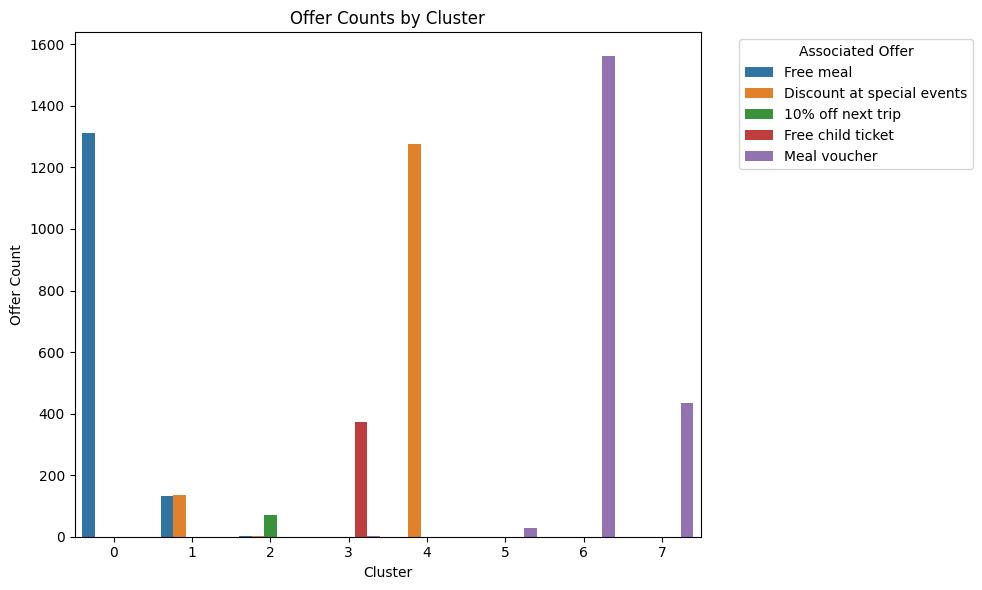

In [ ]:
# Display the result
offer_counts = user_features.groupby('cluster')['recommended_offer'].value_counts().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=offer_counts, x='cluster', y='count', hue='recommended_offer')

# Customize the plot
plt.title("Offer Counts by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Offer Count")
plt.legend(title="Associated Offer", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Predictive Modeling with Random Forest

Accuracy: 0.9899856938483548
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       737
           1       0.93      0.97      0.95       235
           2       0.96      0.92      0.94        50
           3       0.99      0.96      0.98       383
           4       1.00      1.00      1.00      1039
           5       0.99      0.92      0.95       110
           6       1.00      1.00      1.00      1298
           7       0.97      1.00      0.99       342

    accuracy                           0.99      4194
   macro avg       0.98      0.97      0.97      4194
weighted avg       0.99      0.99      0.99      4194



<ipython-input-213-98844ba95e5c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_features.values, y=sorted_features.index, palette='Blues_r')


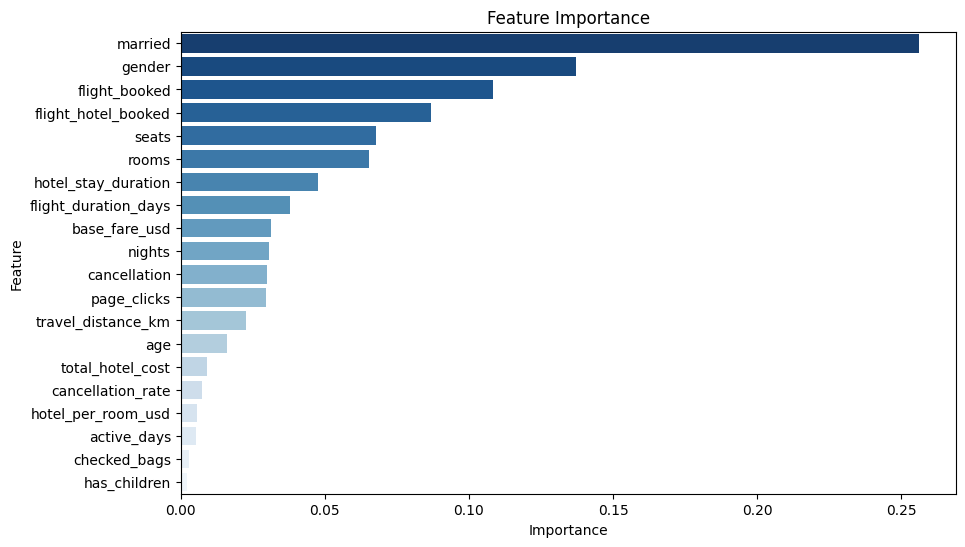

In [ ]:
# Split Data
X = data_numeric[features]
y = data["cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))
feature_importances = pd.Series(model.feature_importances_, index=features)
sorted_features = feature_importances.sort_values(ascending=False)

# Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_features.values, y=sorted_features.index, palette='Blues_r')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(False)
plt.show()